# OpenDC Reproducibility Capsule
**Version:** 1.0.0

Welcome to OpenDC reproducibility capsule. This capsule aims to foster reproducible research practices and aid researchers in automatically making reproducible experiments.
The capsule consists of three main parts: ```Topology Generation```, ```Experiment Generation``` and ```File Selection and Running``` for experiment files. Each section is preceded by instructions on how to use them.

In [1]:
#Imports:
import ipywidgets as widgets
from IPython.display import display
import shutil

from src.template_loader import *
from src.topology_generator import *
from src.experiment_generator import *
from src.runner import *
from src.exporter import *
from src.utils import *
from src.validator import *


# Run all experiments
To run all of the experiments click the button below. This is intended for the result verfication of the capsule, for this purpose rerun experiments are renamed repr_original name to distinguish from original.

In [2]:
run_all_experiments_button = widgets.Button(description="Run all experiments")
output_run_all = widgets.Output()

compare_results_button = widgets.Button(description="Compare Outputs")
output_comparison = widgets.Output()


def on_run_everything_clicked(b):
    with output_run_all:
        output_run_all.clear_output()
        all_experiments = []

        for f in safe_listdir("experiments"):
            if f.endswith(".json") and not f.startswith("repr_"):
                original_path = f"experiments/{f}"
                repr_name = f"repr_{f}"
                repr_path = f"experiments/{repr_name}"

                shutil.copyfile(original_path, repr_path)

                try:
                    with open(repr_path, "r") as file:
                        exp_data = json.load(file)

                    exp_data["name"] = repr_name  # Update name inside the JSON

                    with open(repr_path, "w") as file:
                        json.dump(exp_data, file, indent=4)
                except Exception as e:
                    print(f"Failed to update experiment file '{repr_name}': {e}")
                    continue
                all_experiments.append({"name": repr_name})

        if not all_experiments:
            print("No experiments found to run.")
        else:
            print(f"Running {len(all_experiments)} reproducibility experiments...")
            run_all_experiments(all_experiments)


def on_compare_clicked(b):
    with output_comparison:
        output_comparison.clear_output()
        compare_all_experiments_outputs()    

run_all_experiments_button.on_click(on_run_everything_clicked)
compare_results_button.on_click(on_compare_clicked)

display(
    run_all_experiments_button,
    output_run_all,
    compare_results_button,
    output_comparison
)

Button(description='Run all experiments', style=ButtonStyle())

Output()

Button(description='Compare Outputs', style=ButtonStyle())

Output()

# Topology Generation
This module is used to generate or customize topologies. It first requires to select a base topology either from templates or user provided. Based on this either values provided or carbon traces and batteries can be configured. These tasks are so far mutually exclusive.

For value configuration:

For carbon and battery configuration:

In [ ]:
name_selector_topo = widgets.Text(placeholder='Enter topology name', description='Name:', disabled=False)
# ---------------Topology Widgets-------------------------------------------------------------------------------------
topology_selector_topo = widgets.Dropdown(options=['[None]'] + safe_listdir("templates/topologies"), description='Topology:')
topology_upload_topo = widgets.FileUpload(accept='.json', multiple=False, description='Upload Topology')
topology_row_topo = widgets.HBox([topology_selector_topo, topology_upload_topo])

# ---------------Carbon Widgets-------------------------------------------------------------------------------------
carbon_selector = widgets.SelectMultiple(
    options=['[Keep original]'] + ['[Select All]'] + safe_listdir("carbon_traces"),
    description='Carbon:'
)
carbon_upload = widgets.FileUpload(accept='.parquet', multiple=False, description='Upload Carbon Traces')
carbon_row = widgets.HBox([carbon_selector, carbon_upload]) 

# ------------------ NoH --------------------------------------------------------------------------------------------
NoH_input = widgets.Text(
    placeholder='Enter number, list or range (e.g. 1, 2, 3 or 1-10:1)',
    description='# Hosts:',
    disabled=False
)

# -----------------Battery Values -----------------------------------------------------------------------------------
battery_capacity_input = widgets.Text(
    value='100',
    placeholder='Enter number, list or range (e.g. 100, 200 or 100-300:50)',
    description='Battery Capacity:',
    disabled=False
)

starting_CI_input = widgets.Text(
    value='0.1',
    placeholder='Enter number, list or range (e.g. 0.1, 0.2)',
    description='Start CI:',
    disabled=False
)

charging_speed_input = widgets.Text(
    value='1000',
    placeholder='Enter number, list or range (e.g. 1000, )',
    description='Charging Speed:',
    disabled=False
)

add_battery_checkbox = widgets.Checkbox(
    value=False,
    description='Include Battery',
    disabled=False
)

battery_row = widgets.VBox([
    battery_capacity_input,
    starting_CI_input,
    charging_speed_input,
])

# ------------------ CPU and Memory Inputs -----------------------------------------------------------------------------------
cpu_count_input = widgets.Text(
    placeholder='Enter CPU count, list or range (e.g. 48, 64, or 32-96:16)',
    description='CPU Count:',
    disabled=False
)

cpu_speed_input = widgets.Text(
    placeholder='Enter CPU speed, list or range (e.g. 2100, 2500)',
    description='CPU Speed:',
    disabled=False
)

memory_size_input = widgets.Text(
    placeholder='Enter memory size, list or range (e.g. 100000, 150000)',
    description='Memory Size:',
    disabled=False
)

cluster_input = widgets.Checkbox(
    value=False,
    description="Create with multiple clusters",
    disabled=False
)

cpu_memory_row = widgets.VBox([cpu_count_input, cpu_speed_input, memory_size_input, cluster_input])

#-------------------------------Power Model Widgets ------------------------------------------------

# ---------- Power-model widgets -------------------------------------------------
power_model_types = ["constant", "sqrt", "linear", "square", "cubic"]
power_model_type_input   = widgets.Dropdown(options=power_model_types,
                                description="Model:")

power_model_idle_input = widgets.Text(placeholder="idle W",  description="idlePower:")
power_model_max_input = widgets.Text(placeholder="max  W",  description="maxPower:")
power_model_power_input = widgets.Text(placeholder="power W", description="power:")

power_model_row = widgets.VBox([power_model_type_input, power_model_idle_input, power_model_max_input, power_model_power_input])

generate_topology_button = widgets.Button(description="Generate Topology Carbon and Batteries")

output_topology = widgets.Output()

def on_generate_topology_clicked(b):
    with output_topology:
        output_topology.clear_output()

        if topology_upload_topo.value:
            topology_file = save_uploaded_file(topology_upload_topo, "topologies")[0]
        else:
            topology_file = topology_selector_topo.value
            if topology_file == "[None]":
                topology_file = None

        if carbon_upload.value:
            carbon_file = save_uploaded_file(carbon_upload, "carbon_traces")
            carbon_values = carbon_file
        else:
            carbon_values = clean_selection(carbon_selector.value, safe_listdir("carbon_traces"))

        NoH_values = parse_input(NoH_input.value)
        battery_capacity_values = parse_input(battery_capacity_input.value)
        starting_CI_values = parse_input(starting_CI_input.value)
        charging_speed_values = parse_input(charging_speed_input.value)
        
        include_battery = add_battery_checkbox.value

        cpu_count_values = parse_input(cpu_count_input.value)
        cpu_speed_values = parse_input(cpu_speed_input.value)
        memory_size_values = parse_input(memory_size_input.value)

        power_model_type = power_model_type_input.value
        power_model_idle = power_model_idle_input.value
        power_model_max = power_model_max_input.value
        power_model_power = power_model_power_input.value
        
        name = name_selector_topo.value
        apply_to_multiple_clusters = cluster_input.value
        
        update_topology_values(
            topology_file = topology_file,
            core_count_list = cpu_count_values,
            core_speed_list = cpu_speed_values,
            memory_size_list = memory_size_values,
            multiple_clusters = apply_to_multiple_clusters,
            carbon_list = carbon_values,
            NoH_list = NoH_values,
            battery_capacity_list = battery_capacity_values,
            starting_CI_list = starting_CI_values,
            charging_speed_list = charging_speed_values,
            include_battery = include_battery,
            name = name,
            power_model_type=power_model_type,
            power_model_idle=power_model_idle,
            power_model_max=power_model_max,
            power_model_power=power_model_power

        )


generate_topology_button.on_click(on_generate_topology_clicked)


display(
    widgets.VBox([
        widgets.HTML("<b>OpenDC Topology Configuration</b>"),
        name_selector_topo,
        topology_row_topo,
        widgets.HTML("<b>Value configuration</b>"),
        cpu_memory_row,
        widgets.HTML("<b>Carbon configuration</b>"),
        carbon_row,
        NoH_input,
        widgets.HTML("<b>Battery configuration</b>"),
        add_battery_checkbox,
        battery_row,
        widgets.HTML("<b>Power Model configuration</b>"),
        power_model_row,
        generate_topology_button,
        output_topology
    ])
)

# Add multiple clusters, cleanup the code


# Experiment Generation

In [11]:

name_selector = widgets.Text(placeholder='Enter experiment name', description='Name:', disabled=False)


#----------------------------------Experiment Widgets------------------------------------------------------------------
experiment_selector = widgets.Dropdown(options=['[None]'] + safe_listdir("templates/experiments"), description='Select Template:')
experiment_upload = widgets.FileUpload(accept='.json', multiple=False, description='Upload Experiment')
experiment_row = widgets.HBox([experiment_selector, experiment_upload])

#---------------------------------File Selection Widgets----------------------------------------------------------------
experiment_queue = []

topology_selector = widgets.SelectMultiple(
    options= ['[Keep original]'] +  ['[Select All]'] + list_topology_files(),
    description='Topologies:'
)

workload_selector = widgets.SelectMultiple(
    options=['[Keep original]'] + ['[Select All]'] + safe_listdir("workload_traces"),
    description='Workloads:'
)

failure_selector = widgets.SelectMultiple(
    options=['[Keep original]'] + ['[Select All]'] + safe_listdir("failure_traces"),
    description='Failures:'
)

remove_selector = widgets.Dropdown(options=[], description='Remove From Queue:')
remove_button = widgets.Button(description="Remove Selected From The Queue")
remove_row = widgets.HBox([remove_selector, remove_button])

topology_upload = widgets.FileUpload(accept='.json', multiple=False, description='Upload Topology')
topology_row = widgets.HBox([topology_selector, topology_upload])

workload_row = widgets.HBox([workload_selector])

failure_upload = widgets.FileUpload(accept='.parquet', multiple=False, description='Upload Failures')
failure_row = widgets.HBox([failure_selector, failure_upload]) 

#-----------------------------------Buttons----------------------------------------------------------------------------
generate_and_queue_experiment_button = widgets.Button(description="Generate and Queue Experiment(s)")
run_all_button = widgets.Button(description="Run All Experiments")
export_button = widgets.Button(description="Export Queued Experiments as ZIP")
export_fast_button = widgets.Button(description="Export All Experiments")
generate_readme_button = widgets.Button(description="Generate README")
gen_and_run_button_row = widgets.HBox([generate_and_queue_experiment_button, run_all_button])
readme_and_export_button_row = widgets.HBox([generate_readme_button, export_button, export_fast_button])

#---------------------------------Allocation Policy Widgets------------------------------------------------------------
prefab_entries = []

policy_options = [
    'Mem', 'MemInv', 'CoreMem', 'CoreMemInv',
    'ActiveServers', 'ActiveServersInv',
    'ProvisionedCores', 'ProvisionedCoresInv',
    'Random', 'TimeShift'
]

policy_dropdown = widgets.SelectMultiple(
        options=policy_options,
        description='Prefab:',
    )


#--------------------------------Checkpoint Widgets--------------------------------------------------------------------
checkpoint_values = {}

checkpoint_interval_input = widgets.Text(
    placeholder='Enter number',
    description='Interval:',
    disabled=False
)

checkpoint_duration_input = widgets.Text(
    placeholder='Enter number',
    description='Duration:',
    disabled=False
)

checkpoint_scaling_input = widgets.Text(
    placeholder='Enter number',
    description='Scaling:',
    disabled=False
)

checkpoint_row = widgets.VBox([
    checkpoint_interval_input,
    checkpoint_duration_input,
    checkpoint_scaling_input
])


#-------------------------------Export Model Widgets-------------------------------------------------------------------
export_model_values = {}

export_options = ["host", "task", "powerSource", "battery", "service"]

export_interval_input = widgets.Text(
    placeholder='Enter number, list, or range (e.g. 36000000, 40000000 or 36000000-40000000:2000000)',
    description='Interval:',
    disabled=False
)

print_frequency_input = widgets.Text(
    placeholder='Enter number, list, or range (e.g. 1, 2 or 1-5:1)',
    description='Print Frequency:',
    disabled=False
)

files_to_export_widget = widgets.SelectMultiple(
    options=export_options,
    description='Files to export:'
)

initial_seed_input = widgets.Text(
    placeholder='Enter number, list, or range (e.g. 1, 2 or 1-5:1)',
    description='Seed:',
    disabled=False
)

number_runs_input = widgets.Text(
    placeholder='Enter a number',
    description='Runs:',
    disabled=False
)


export_model_row = widgets.VBox([
    export_interval_input,
    print_frequency_input,
    files_to_export_widget,
    initial_seed_input,
    number_runs_input
])

output_experiments = widgets.Output()


def on_generate_experiment_clicked(b):
    with output_experiments:
        output_experiments.clear_output()

        experiment = None
        if experiment_upload.value:
            experiment_file = save_uploaded_file(experiment_upload, "experiments")[0]
            refresh_dropdown(experiment_selector, "experiments", experiment_file, False)
            experiment = experiment_file
        else:
            experiment = experiment_selector.value
            if experiment == "[None]":
                experiment = None

        
        name = name_selector.value.strip() or None

        topology_values = save_uploaded_file(topology_upload, "topologies") if topology_upload.value else clean_selection(topology_selector.value, safe_listdir("topologies"))
        workload_values = clean_selection(workload_selector.value, safe_listdir("workloads"))
        failure_values  = save_uploaded_file(failure_upload, "failure_traces") if failure_upload.value else clean_selection(failure_selector.value, safe_listdir("failures"))

        prefab_types = list(policy_dropdown.value)

        checkpoint_interval = checkpoint_interval_input.value if checkpoint_interval_input.value else None
        checkpoint_duration = checkpoint_duration_input.value if checkpoint_duration_input.value else None
        checkpoint_scaling  = checkpoint_scaling_input.value if checkpoint_scaling_input.value else None
        

        export_intervals = parse_input(export_interval_input.value)
        print_frequencies = parse_input(print_frequency_input.value)
        seeds = parse_input(initial_seed_input.value)
        runs = parse_input(number_runs_input.value)

        files_to_export = list(files_to_export_widget.value)

      
        filename = update_experiment_values(
            experiment,
            topology_values,
            workload_values,
            failure_values,
            prefab_types,
            checkpoint_interval,
            checkpoint_duration,
            checkpoint_scaling,
            export_intervals,
            print_frequencies,
            files_to_export,
            name=name,
            seeds=seeds,
            runs=runs
        )

        selections = {
            "name": filename,
            "topology": topology_values,
            "workload": workload_values,
            "failures": failure_values
        }

        experiment_queue.append(selections)
        remove_selector.options = [exp["name"] for exp in experiment_queue]
        print(f"Added experiment to the queue. Total queued: {len(experiment_queue)}")

times = []

def on_run_all_clicked(b):
    global times

    with output_experiments:
        output_experiments.clear_output()
        if validate_experiments(experiment_queue):
            times = run_all_experiments(experiment_queue.copy())

def on_remove_clicked(b):
    with output_experiments:
        output_experiments.clear_output()
        to_remove = remove_selector.value
        if to_remove:
            removed = False
            for i, exp in enumerate(experiment_queue):
                if exp["name"] == to_remove:
                    del experiment_queue[i]
                    removed = True
                    break
            if removed:
                print(f"Removed experiment {to_remove} from queue.")
                remove_selector.options = [exp["name"] for exp in experiment_queue]
            else:
                print(f"Experiment {to_remove} not found in queue.")
        else:
            print("No experiment selected to remove.")

def on_export_clicked(b):
    with output_experiments:
        output_experiments.clear_output()
        create_reproducibility_zip(experiment_queue)
        print("Capsule created")

def on_export_fast_clicked(b):
    with output_experiments:
        output_experiments.clear_output()
        quick_export_all_zip(output_name="reproducibility_capsule.zip")
        print("Capsule created")

def on_generate_readme_clicked(b):
    with output_experiments:
        output_experiments.clear_output()
        global times
        stats = {
                "experiments": times,
                "system_info": get_system_info()
            }
        generate_readme_from_queue(experiment_queue, stats)


generate_and_queue_experiment_button.on_click(on_generate_experiment_clicked)
run_all_button.on_click(on_run_all_clicked)
remove_button.on_click(on_remove_clicked)
export_button.on_click(on_export_clicked)
export_fast_button.on_click(on_export_fast_clicked)
generate_readme_button.on_click(on_generate_readme_clicked)



display(
    widgets.VBox([
        widgets.HTML("<b>OpenDC Experiment Configuration</b>"),
        name_selector,
        experiment_row,
        widgets.HTML("<b>File selection</b>"),
        topology_row,
        workload_row,
        failure_row,
        widgets.HTML("<b>Allocation Policy Configuration</b>"),
        policy_dropdown,
        widgets.HTML("<b>OpenDC Checkpoint Configuration</b>"),
        checkpoint_row,
        widgets.HTML("<b>OpenDC Export Model Configuration</b>"),
        export_model_row,
        widgets.HTML("<b>Configuration Buttons</b>"),
        gen_and_run_button_row,
        readme_and_export_button_row,
        remove_row,
        output_experiments
    ])
)


# Visualization

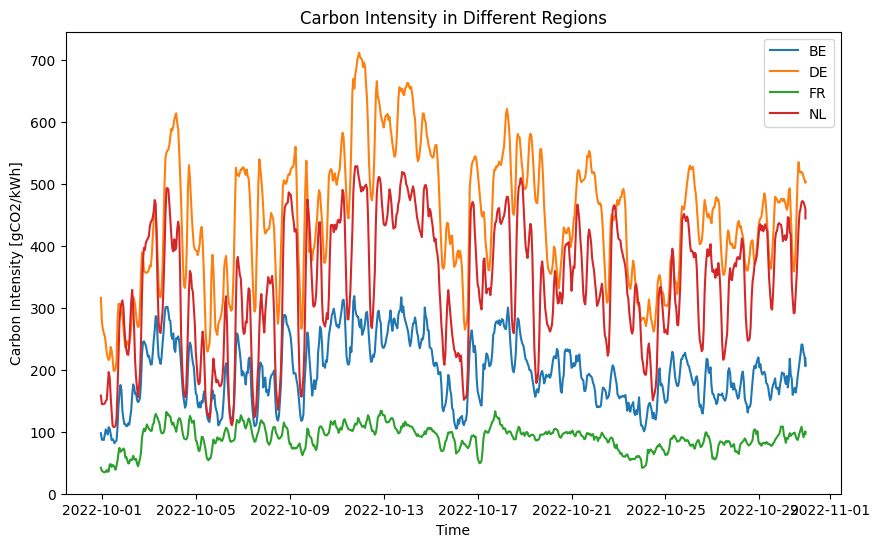

In [5]:
# Visualization functions
# TO-DO: think of the limitations.
# do topology part correct,  try to make them in folders or the naming could just work
# make clear between limitations of the model and implementation, it is not necessarilly always a problem
# talk about what was infeasible to do
# visualizer next time
# search next time
# running experiment in chunks later

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df_host_BE = pd.read_parquet("output/carbon_experiment_json/raw-output/0/seed=0/host.parquet")
df_powerSource_BE = pd.read_parquet("output/carbon_experiment_json/raw-output/0/seed=0/powerSource.parquet")
df_task_BE = pd.read_parquet("output/carbon_experiment_json/raw-output/0/seed=0/task.parquet")
df_service_BE = pd.read_parquet("output/carbon_experiment_json/raw-output/0/seed=0/service.parquet")

df_host_DE = pd.read_parquet("output/carbon_experiment_json/raw-output/1/seed=0/host.parquet")
df_powerSource_DE = pd.read_parquet("output/carbon_experiment_json/raw-output/1/seed=0/powerSource.parquet")
df_task_DE = pd.read_parquet("output/carbon_experiment_json/raw-output/1/seed=0/task.parquet")
df_service_DE = pd.read_parquet("output/carbon_experiment_json/raw-output/1/seed=0/service.parquet")

df_host_FR = pd.read_parquet("output/carbon_experiment_json/raw-output/2/seed=0/host.parquet")
df_powerSource_FR = pd.read_parquet("output/carbon_experiment_json/raw-output/2/seed=0/powerSource.parquet")
df_task_FR = pd.read_parquet("output/carbon_experiment_json/raw-output/2/seed=0/task.parquet")
df_service_FR = pd.read_parquet("output/carbon_experiment_json/raw-output/2/seed=0/service.parquet")

df_host_NL = pd.read_parquet("output/carbon_experiment_json/raw-output/3/seed=0/host.parquet")
df_powerSource_NL = pd.read_parquet("output/carbon_experiment_json/raw-output/3/seed=0/powerSource.parquet")
df_task_NL = pd.read_parquet("output/carbon_experiment_json/raw-output/3/seed=0/task.parquet")
df_service_NL = pd.read_parquet("output/carbon_experiment_json/raw-output/3/seed=0/service.parquet")


plt.figure(figsize=(10, 6))

timestamps = pd.to_datetime(df_powerSource_BE.timestamp_absolute, unit="ms")


plt.plot(timestamps, df_powerSource_BE["carbon_intensity"], label="BE")
plt.plot(timestamps, df_powerSource_DE["carbon_intensity"], label="DE")
plt.plot(timestamps, df_powerSource_FR["carbon_intensity"], label="FR")
plt.plot(timestamps, df_powerSource_NL["carbon_intensity"], label="NL")

plt.legend()
plt.xlabel("Time")
plt.ylim([0, None])
plt.ylabel("Carbon Intensity [gCO2/kWh]")
plt.title("Carbon Intensity in Different Regions")

plt.show()



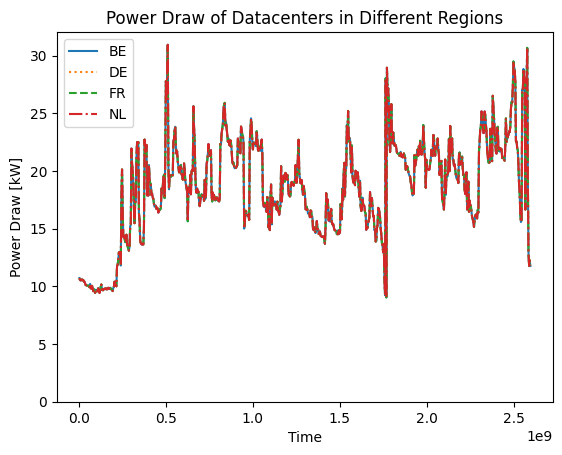

In [6]:
plt.plot(df_powerSource_BE["timestamp"], df_powerSource_BE["power_draw"] / 1000, label="BE")
plt.plot(df_powerSource_DE["timestamp"], df_powerSource_DE["power_draw"] / 1000, label="DE", linestyle=':')
plt.plot(df_powerSource_FR["timestamp"], df_powerSource_FR["power_draw"] / 1000, label="FR", linestyle='--')
plt.plot(df_powerSource_NL["timestamp"], df_powerSource_NL["power_draw"] / 1000, label="NL", linestyle='-.')

plt.legend()
plt.xlabel("Time")
plt.ylim([0, None])
plt.ylabel("Power Draw [kW]")
plt.title("Power Draw of Datacenters in Different Regions")

plt.show()

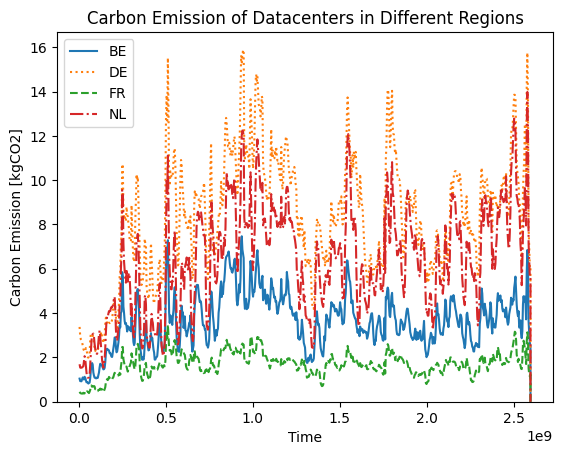

In [7]:
plt.plot(df_powerSource_BE["timestamp"], df_powerSource_BE["carbon_emission"] / 1000, label="BE")
plt.plot(df_powerSource_DE["timestamp"], df_powerSource_DE["carbon_emission"] / 1000, label="DE", linestyle=':')
plt.plot(df_powerSource_FR["timestamp"], df_powerSource_FR["carbon_emission"] / 1000, label="FR", linestyle='--')
plt.plot(df_powerSource_NL["timestamp"], df_powerSource_NL["carbon_emission"] / 1000, label="NL", linestyle='-.')

plt.legend()
plt.xlabel("Time")
plt.ylim([0, None])
plt.ylabel("Carbon Emission [kgCO2]")
plt.title("Carbon Emission of Datacenters in Different Regions")

plt.show()